# Training a neural network on a binary-classification task using TensorFlow

This example trains a neural network on a binary-classification task and is designed to present a typical TensorFlow workflow for training neural networks.

In [1]:
import numpy as np
np.random.seed(1234)
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D as plt3d
%matplotlib inline

/home/stefan/py2_virtualenv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Create the dataset

The dataset is drawn from 2D-Gaussian distributions with different means for the signal and background class. See below the plots of the distributions.

In [2]:
num_events = 10000

signal_mean = [1.0, 1.0]
signal_cov = [[1.0, 0.0],
              [0.0, 1.0]]
signal_train = np.random.multivariate_normal(
        signal_mean, signal_cov, num_events)
signal_val = np.random.multivariate_normal(
        signal_mean, signal_cov, num_events)

background_mean = [-1.0, -1.0]
background_cov = [[1.0, 0.0],
                  [0.0, 1.0]]
background_train = np.random.multivariate_normal(
        background_mean, background_cov, num_events)
background_val = np.random.multivariate_normal(
        background_mean, background_cov, num_events)

data_train = np.vstack([signal_train, background_train])
labels_train = np.vstack([np.ones((num_events, 1)), np.zeros((num_events, 1))])

data_val = np.vstack([signal_val, background_val])
labels_val = np.vstack([np.ones((num_events, 1)), np.zeros((num_events, 1))])

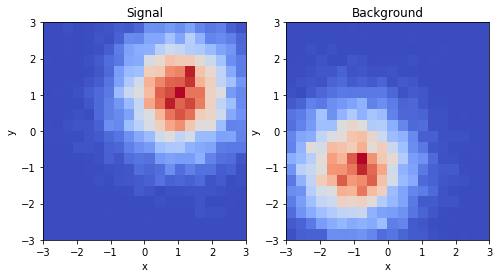

In [3]:
range_ = ((-3, 3), (-3, 3))
plt.figure(0, figsize=(8,4))
plt.subplot(1,2,1); plt.title("Signal")
plt.xlabel("x"), plt.ylabel("y")
plt.hist2d(signal_train[:,0], signal_train[:,1],
        range=range_, bins=20, cmap=cm.coolwarm)
plt.subplot(1,2,2); plt.title("Background")
plt.hist2d(background_train[:,0], background_train[:,1],
        range=range_, bins=20, cmap=cm.coolwarm)
plt.xlabel("x"), plt.ylabel("y");

## Define the neural network architecture

The architecture of the neural network is defined below. Note that the node before applying the final acitvation function, the so-called logits, is return because the loss function will use this later on.

The architecture is a simple feed-forward network with a single hidden layer, such as shown below.

![Model](gaussian_model.svg)

In [4]:
def model(x):
    with tf.variable_scope("model") as scope:
        w1 = tf.get_variable('w1', shape=(2, 100), dtype=tf.float64,
                initializer=tf.random_normal_initializer(stddev=0.1))
        b1 = tf.get_variable('b1', shape=(100), dtype=tf.float64,
                initializer=tf.constant_initializer(0.1))
        w2 = tf.get_variable('w2', shape=(100, 1), dtype=tf.float64,
                initializer=tf.random_normal_initializer(stddev=0.1))
        b2 = tf.get_variable('b2', shape=(1), dtype=tf.float64,
                initializer=tf.constant_initializer(0.1))
    
    l1 = tf.nn.relu(tf.add(b1, tf.matmul(x, w1)))
    logits = tf.add(b2, tf.matmul(l1, w2))
    return logits, tf.sigmoid(logits)

x = tf.placeholder(tf.float64, shape=[None, 2])
logits, f = model(x)

## Add training operations to the graph

The inference part of the graph is already defined above. Now, we have to add on top the operations needed for adapting the free parameters. For training, we need to define a loss function, here the cross-entropy, and a minimizer algorithm, which will optimize the weights of the network with each gradient step.

In [5]:
labels = tf.placeholder(tf.float64, shape=[None, 1])
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits))
minimize_loss = tf.train.AdamOptimizer().minimize(loss)

## Run the training

Using plain TensorFlow, you have to call each optimization step explicitely using the above defined training operations. In this example, we are doing this in the most simple way by using the full dataset for each gradient-step computation.

See below the convergence of the loss for the training and validation dataset.

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

loss_train = []
loss_val = []
for i_step in range(100):
    loss_, _ = sess.run([loss, minimize_loss],
                        feed_dict={x: data_train, labels: labels_train})
    loss_train.append(loss_)
    
    loss_ = sess.run(loss, feed_dict={x: data_val, labels: labels_val})
    loss_val.append(loss_)

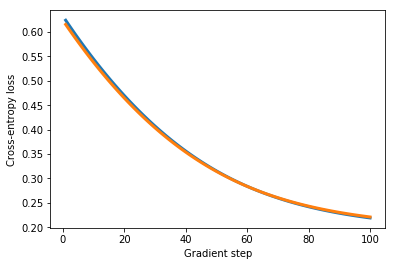

In [7]:
plt.plot(range(1, len(loss_train)+1), loss_train, lw=3, label="Training loss")
plt.plot(range(1, len(loss_train)+1), loss_val, lw=3, label="Validation loss")
plt.xlabel("Gradient step"), plt.ylabel("Cross-entropy loss");

## Inspect the learned function

The training fitted the neural network function to return the signal probability for a given input. Because we have chosen an example of a low dimensionality, we can easily visualize this decision function and compare the result with our expectation from the distribution of the dataset shown above.

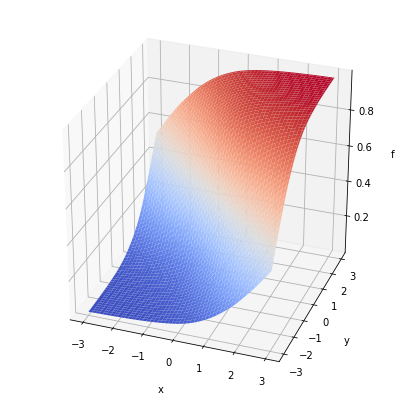

In [8]:
num_points = 100
grid = np.zeros((num_points**2, 2))
count = 0
for x_ in np.linspace(-3.0, 3.0, num_points):
    for y_ in np.linspace(-3.0, 3.0, num_points):
        grid[count, :] = (x_, y_)
        count += 1
        
f_ = sess.run(f, feed_dict={x: grid})

x = np.reshape(grid[:, 0], (num_points, num_points)).T
y = np.reshape(grid[:, 1], (num_points, num_points)).T
z = np.reshape(f_, (num_points, num_points)).T

fig = plt.figure(figsize=(7, 7))
ax = fig.gca(projection="3d")
ax.view_init(30, -70)
ax.plot_surface(x, y, z, cmap=cm.coolwarm)
ax.set_xlabel("x", labelpad=12)
ax.set_ylabel("y", labelpad=12)
ax.set_zlabel("f", labelpad=12);